In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import pandas as pd
import heapq
from collections import defaultdict
from tqdm import tqdm
from google.colab import drive

In [ ]:
def load_data():
    with open('/kaggle/input/trainingdata/train_data1.json', 'r') as file:
        data_train = json.load(file)

    with open('/kaggle/input/nmt-data/val_data1.json', 'r') as file:
        data_val = json.load(file)
    return data_train, data_val
data_train, data_val = load_data()
# print(data_train)

In [ ]:
def train_json_to_list(data, language_pair):

    source_list, target_list, ids_list = [], [], []

    for lang_pair, lang_pair_data in data.items():
        if lang_pair == language_pair:
            for data_type, data_entries in lang_pair_data.items():
                for entry_id, entry_data in data_entries.items():
                    source = entry_data["source"]
                    target = entry_data["target"]

                    source_list.append(source)
                    target_list.append(target)
                    ids_list.append(entry_id)

    return source_list, target_list, ids_list


In [ ]:
def val_json_to_list(data , language_pair):
  source_list, ids_list = [], []
  for lang_pair, lang_pair_data in data.items():
      if lang_pair == language_pair:
          for data_type, data_entries in lang_pair_data.items():
              for entry_id, entry_data in data_entries.items():
                  source = entry_data["source"]
                  source_list.append(source)
                  ids_list.append(entry_id)

  return source_list, ids_list

In [ ]:
source_train_ben, target_train_ben , train_ids_ben  = train_json_to_list(data_train, "English-Bengali")
source_val_ben, val_ids_ben = val_json_to_list(data_val, "English-Bengali")

source_train_hin, target_train_hin, train_ids_hin = train_json_to_list(data_train, "English-Hindi")
source_val_hin, val_ids_hin = val_json_to_list(data_val, "English-Hindi")

# print(source_val_ben[1])
# print("\n")
# print(source_val_hin[1])


In [ ]:
#Augmented Datasets

# def load_aug_csv(path, src_col, tgt_col):
#     df = pd.read_csv(path)
#     df = df[[src_col, tgt_col]].dropna().astype(str)
#     df = df[(df[src_col].str.strip() != "") & (df[tgt_col].str.strip() != "")]
#     return df[src_col].tolist(), df[tgt_col].tolist()

# aug_source_train_hi, aug_target_train_hin = load_aug_csv("/kaggle/input/aug-data/en_hi_dataset_100k.csv", "english", "hindi")

# aug_source_train_bn, aug_target_bn = load_aug_csv("/kaggle/input/aug-data/en_bn_dataset_100k.csv", "english", "bengali")

# # English–Hindi
# start_idx_hi = len(train_ids_hin)
# train_ids_hin.extend([f"aug-hi-{i+start_idx_hi}" for i in range(len(aug_source_train_hi))])
# source_train_hin.extend(aug_source_train_hi)
# target_train_hin.extend(aug_target_train_hin)

# # English–Bengali
# start_idx_bn = len(train_ids_ben)
# train_ids_ben.extend([f"aug-bn-{i+start_idx_bn}" for i in range(len(aug_source_train_bn))])
# source_train_ben.extend(aug_source_train_bn)
# target_train_ben.extend(aug_target_bn)

# assert len(source_train_hin) == len(target_train_hin) == len(train_ids_hin)
# assert len(source_train_ben) == len(target_train_ben) == len(train_ids_ben)

# print(f"En–Hi train total: {len(source_train_hin)} (added {len(aug_source_train_hi)})")
# print(f"En–Bn train total: {len(source_train_ben)} (added {len(aug_source_train_bn)})")

In [ ]:
#BPE Tokenizer from Assignment 2

class Node:
    def __init__(self, token_id):
        self.token_id = token_id
        self.prev = None
        self.next = None

class BPETokenizer:
    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        self.merges = {}
        self.token_to_id = {}
        self.id_to_token = {}

    def initialize_vocab(self):
        reserved = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]
        self.vocab = {i: tok for i, tok in enumerate(reserved)}
        self.inverse_vocab = {tok: i for i, tok in self.vocab.items()}
        return len(self.vocab)

    def build_corpus(self, text, next_token_id):
        words = [list(w) + ["</w>"] for w in text.strip().split()]
        corpus = []
        for w in words:
            head, prev = None, None
            for ch in w:
                if ch not in self.inverse_vocab:
                    self.vocab[next_token_id] = ch
                    self.inverse_vocab[ch] = next_token_id
                    next_token_id += 1
                node = Node(self.inverse_vocab[ch])
                if prev:
                    prev.next, node.prev = node, prev
                else:
                    head = node
                prev = node
            corpus.append(head)
        return corpus, next_token_id

    def count_pairs(self, corpus):
        pair_occurrences = defaultdict(set)
        for head in corpus:
            node = head
            while node and node.next:
                pair_occurrences[(node.token_id, node.next.token_id)].add(node)
                node = node.next
        return pair_occurrences

    def merge_pair(self, pair, new_id, pair_occurrences, heap):
        t1, t2 = pair
        new_tok = self.vocab[t1] + self.vocab[t2]
        self.vocab[new_id] = new_tok
        self.inverse_vocab[new_tok] = new_id
        affected = list(pair_occurrences[pair])
        pair_occurrences[pair].clear()
        for node in affected:
            if not node.next or node.token_id != t1 or node.next.token_id != t2:
                continue
            node.token_id = new_id
            removed = node.next
            node.next = removed.next
            if removed.next:
                removed.next.prev = node
            if node.prev:
                old = (node.prev.token_id, t1)
                pair_occurrences[old].discard(node.prev)
                new = (node.prev.token_id, node.token_id)
                pair_occurrences[new].add(node.prev)
                heapq.heappush(heap, (-len(pair_occurrences[new]), new))
            if node.next:
                old = (t2, node.next.token_id)
                pair_occurrences[old].discard(node)
                new = (node.token_id, node.next.token_id)
                pair_occurrences[new].add(node)
                heapq.heappush(heap, (-len(pair_occurrences[new]), new))

    def train(self, text, vocab_size=5000):
        next_id = self.initialize_vocab()
        corpus, next_id = self.build_corpus(text, next_id)
        pair_occurrences = self.count_pairs(corpus)
        heap = [(-len(nodes), pair) for pair, nodes in pair_occurrences.items()]
        heapq.heapify(heap)
        while len(self.vocab) < vocab_size and heap:
            freq, pair = heapq.heappop(heap)
            freq = -freq
            if freq == 0 or len(pair_occurrences[pair]) != freq:
                continue
            self.merges[pair] = next_id
            self.merge_pair(pair, next_id, pair_occurrences, heap)
            next_id += 1
        self.token_to_id = {tok: tid for tid, tok in self.vocab.items()}
        self.id_to_token = {tid: tok for tid, tok in self.vocab.items()}

    def tokenize(self, text):
        words = [list(w) + ["</w>"] for w in text.strip().split()]
        tokens = []
        for w in words:
            ids = [self.inverse_vocab.get(ch, self.token_to_id["<UNK>"]) for ch in w]
            merged = True
            while merged:
                merged, i = False, 0
                while i < len(ids) - 1:
                    pair = (ids[i], ids[i + 1])
                    if pair in self.merges:
                        ids[i] = self.merges[pair]
                        ids.pop(i + 1)
                        merged = True
                    else:
                        i += 1
            tokens.extend(ids)
        return tokens


    def decode(self, token_ids):
        specials = {self.token_to_id.get("<PAD>"), self.token_to_id.get("<UNK>"),
                    self.token_to_id.get("<SOS>"), self.token_to_id.get("<EOS>")}
        words, cur = [], []
        for tid in token_ids:
            if tid in specials:
                continue
            tok = self.id_to_token.get(tid, "<UNK>")
            if tok.endswith("</w>"):
                cur.append(tok[:-4])
                if cur:
                    words.append("".join(cur))
                cur = []
            else:
                cur.append(tok)
        if cur:
            words.append("".join(cur))
        return " ".join(words).strip()


In [ ]:
def clean_text(text, l="en"):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[“”‘’]', '"', text)
    if l == "hi":
        text = re.sub(r'[^\u0900-\u097F\s.,!?]', '', text)
    elif l == "bn":
        text = re.sub(r'[^\u0980-\u09FF\s.,!?।]', '', text)
    else:
        text = re.sub(r'[^\w\s.,!?]', '', text)
        text = text.lower()
    return text

In [ ]:
bpe=BPETokenizer()
#concatenatte all hindi and english text for tokenizer training also test vocab means sourse english,target hindi,target bengali,val source english
#sperately training is bad for most the cases
bpe.train(" ".join([clean_text(s, "en") for s in source_train_hin] +
                    [clean_text(t, "hi") for t in target_train_hin] +
                    [clean_text(s, "en") for s in source_train_ben] +
                    [clean_text(t, "bn") for t in target_train_ben] +
                    [clean_text(s, "en") for s in source_val_ben] +
                    [clean_text(s, "en") for s in source_val_hin]), vocab_size=40000)
# print("bpe trained :")

In [ ]:
#Ensure special tokens are in the tokenizer vocab
#Add special tokens if not present
#Adding special tokens to both tokenizers
#Initially I had two tokenizers for hindi and bengali but now using single tokenizer for both languages because of better vocabulary coverage for merged tokenizer training

for tokenizer in [bpe,bpe]:
    for t in ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]:
        if t not in tokenizer.token_to_id:
            new_id = len(tokenizer.token_to_id)
            tokenizer.token_to_id[t] = new_id
            tokenizer.id_to_token[new_id] = t

In [ ]:
SEQ_LENGTH = 50
# Padding and encoding function
# Adds <SOS> and <EOS> tokens and pads/truncates to max_length
# Returns list of token IDs
# eg: pad_encode(tokenizer, "Hello world", 10) and its output is [2, 15, 23, 3, 0, 0, 0, 0, 0, 0] assuming <SOS>=2, <EOS>=3, <PAD>=0, "Hello"=15, "world"=23
# Here, max_length includes <SOS> and <EOS> tokens
# So for a max_length of 10, the actual text can be up to 8 tokens long because of the two special tokens i,e <SOS> and <EOS>

def pad_encode(tokenizer, sent, max_length):
    sos = [tokenizer.token_to_id["<SOS>"]]
    eos = [tokenizer.token_to_id["<EOS>"]]
    pad = [tokenizer.token_to_id["<PAD>"]]
    encoded = tokenizer.tokenize(sent)
    if len(encoded) < max_length - 2:
        n_pads = max_length - 2 - len(encoded)
        return sos + encoded + eos + pad * n_pads
    else:
        return sos + encoded[:max_length - 2] + eos

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# Custom Dataset class for translation data for our Translation Task
# It takes source and target tensors and implements __getitem__ and __len__ methods which return source-target pair at given index and length of dataset respectively
# This class can be used with PyTorch DataLoader for batching and shuffling data during training and evaluation and inference time

class TranslationDataset(Dataset):
    def __init__(self, src_tensor, tgt_tensor):
        assert len(src_tensor) == len(tgt_tensor), \
            f"Source and target lengths differ: {len(src_tensor)} vs {len(tgt_tensor)}"
        self.src = src_tensor
        self.tgt = tgt_tensor

    def __getitem__(self, index):
        return self.src[index], self.tgt[index]

    def __len__(self):
        return len(self.src)

In [ ]:

#encoding and padding the datasets
#for bengali
#en_train_encoded_ben=items of list of list where each inner list is token ids of a sentence
#de_train_encoded_ben=items of list of list where each inner list is token ids of a sentence
#en_val_encoded_ben=items of list of list where each inner list is token ids of a sentence
#de_val_encoded_ben=items of list of list where each inner list is token ids of a sentence


en_train_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_train_ben]
de_train_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in target_train_ben]
en_val_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_ben]
de_val_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_ben]
#for hindi
#en_train_encoded_hin=items of list of list where each inner list is token ids of a sentence
#de_train_encoded_hin=items of list of list where each inner list is token ids of a sentence
#en_val_encoded_hin=items of list of list where each inner list is token ids of a sentence
#de_val_encoded_hin=items of list of list where each inner list is token ids of a sentence

en_train_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_train_hin]
de_train_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in target_train_hin]
en_val_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_hin]
de_val_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_hin]

#converting to numpy arrays then to tensors and creating dataloaders in dataoader function
train_x_ben = np.array(en_train_encoded_ben)
train_y_ben = np.array(de_train_encoded_ben)
test_x_ben = np.array(en_val_encoded_ben)
test_y_ben = np.array(de_val_encoded_ben)
#for hindi
train_x_hin = np.array(en_train_encoded_hin)
train_y_hin = np.array(de_train_encoded_hin)
test_x_hin = np.array(en_val_encoded_hin)
test_y_hin = np.array(de_val_encoded_hin)
BATCH_SIZE =32
#for bengaki
train_ds_ben = TranslationDataset(torch.from_numpy(train_x_ben), torch.from_numpy(train_y_ben))
test_ds_ben = TranslationDataset(torch.from_numpy(test_x_ben), torch.from_numpy(test_y_ben))
train_dl_ben = DataLoader(train_ds_ben, shuffle=True, batch_size=BATCH_SIZE, drop_last=False)
test_dl_ben = DataLoader(test_ds_ben, shuffle=False, batch_size=BATCH_SIZE)

#for hindi
train_ds_hin = TranslationDataset(torch.from_numpy(train_x_hin), torch.from_numpy(train_y_hin))
test_ds_hin = TranslationDataset(torch.from_numpy(test_x_hin), torch.from_numpy(test_y_hin))
train_dl_hin = DataLoader(train_ds_hin, shuffle=True, batch_size=BATCH_SIZE, drop_last=False)
test_dl_hin = DataLoader(test_ds_hin, shuffle=False, batch_size=BATCH_SIZE)


Training Bengali model...
training started : 
device: cuda
total parameter is :  33115438
Epoch 1/50 | loss: 6.4796 | lr: 0.000100
Epoch 2/50 | loss: 5.7527 | lr: 0.000100
Epoch 3/50 | loss: 5.5176 | lr: 0.000100
Epoch 4/50 | loss: 5.3758 | lr: 0.000100
Epoch 5/50 | loss: 5.2656 | lr: 0.000100
Epoch 6/50 | loss: 5.1862 | lr: 0.000100
Epoch 7/50 | loss: 5.1129 | lr: 0.000100
Epoch 8/50 | loss: 5.0585 | lr: 0.000100
Epoch 9/50 | loss: 5.0125 | lr: 0.000100
Epoch 10/50 | loss: 4.9743 | lr: 0.000100
Epoch 11/50 | loss: 4.9270 | lr: 0.000100
Epoch 12/50 | loss: 4.8956 | lr: 0.000100
Epoch 13/50 | loss: 4.8666 | lr: 0.000100
Epoch 14/50 | loss: 4.8342 | lr: 0.000100
Epoch 15/50 | loss: 4.8140 | lr: 0.000100
Epoch 16/50 | loss: 4.7826 | lr: 0.000100
Epoch 17/50 | loss: 4.7624 | lr: 0.000100
Epoch 18/50 | loss: 4.7413 | lr: 0.000100
Epoch 19/50 | loss: 4.7178 | lr: 0.000100
Epoch 20/50 | loss: 4.7009 | lr: 0.000100
Epoch 21/50 | loss: 4.6763 | lr: 0.000100
Epoch 22/50 | loss: 4.6587 | lr: 0.00

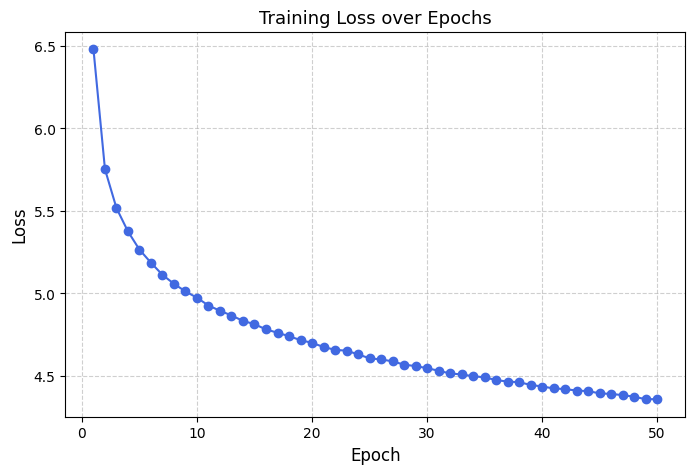


Training Hindi model
training started : 
device: cuda
total parameter is :  33123646
Epoch 1/50 | loss: 6.4956 | lr: 0.000100
Epoch 2/50 | loss: 5.7563 | lr: 0.000100
Epoch 3/50 | loss: 5.5267 | lr: 0.000100
Epoch 4/50 | loss: 5.3763 | lr: 0.000100
Epoch 5/50 | loss: 5.2686 | lr: 0.000100
Epoch 6/50 | loss: 5.1807 | lr: 0.000100
Epoch 7/50 | loss: 5.1087 | lr: 0.000100
Epoch 8/50 | loss: 5.0532 | lr: 0.000100
Epoch 9/50 | loss: 4.9984 | lr: 0.000100
Epoch 10/50 | loss: 4.9483 | lr: 0.000100
Epoch 11/50 | loss: 4.9090 | lr: 0.000100
Epoch 12/50 | loss: 4.8718 | lr: 0.000100
Epoch 13/50 | loss: 4.8308 | lr: 0.000100
Epoch 14/50 | loss: 4.8095 | lr: 0.000100
Epoch 15/50 | loss: 4.7716 | lr: 0.000100
Epoch 16/50 | loss: 4.7405 | lr: 0.000100
Epoch 17/50 | loss: 4.7126 | lr: 0.000100
Epoch 18/50 | loss: 4.6964 | lr: 0.000100
Epoch 19/50 | loss: 4.6669 | lr: 0.000100
Epoch 20/50 | loss: 4.6513 | lr: 0.000100
Epoch 21/50 | loss: 4.6291 | lr: 0.000100
Epoch 22/50 | loss: 4.6082 | lr: 0.000100

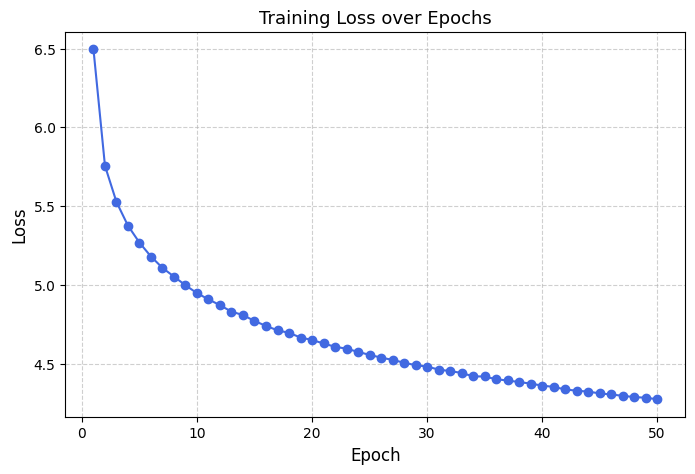


Generating Bengali translations
Saved Bengali predictions answer_ben.csv

Generating Hindi translations
Saved Hindi predictions answer_hi.csv


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

class LockedDropout(nn.Module):
    def __init__(self, p=0.0):
        super().__init__()
        self.p = float(p)
    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        B, T, D = x.size()
        mask = x.new_empty(B, 1, D).bernoulli_(1 - self.p) / (1 - self.p)
        return x * mask


class EncoderLSTM(nn.Module):
    """
    Bidirectional LSTM encoder.
    - input_size: source vocab size
    - hidden_size: model size (decoder size). BiLSTM uses hidden_size//2 per direction.
    """
    def __init__(self, input_size, hidden_size=256, num_layers=2,
                 emb_dropout=0.1, rnn_dropout=0.1, padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.h_per_dir   = hidden_size // 2

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=padding_idx)
        self.lockdrop  = LockedDropout(emb_dropout)
        self.dropout   = nn.Dropout(emb_dropout)

        self.rnn = nn.LSTM(
            input_size   = hidden_size,
            hidden_size  = self.h_per_dir,
            num_layers   = num_layers,
            batch_first  = True,
            bidirectional= True,
            dropout      = rnn_dropout if num_layers > 1 else 0.0
        )

        self.fc_h = nn.Linear(hidden_size, hidden_size)
        self.fc_c = nn.Linear(hidden_size, hidden_size)
        self.ln_out = nn.LayerNorm(hidden_size)

    def forward(self, x):
        """
        x: LongTensor (B, T_src)
        returns:
          enc_outputs: (B, T_src, hidden_size)
          dec_init:    (h0, c0) each (num_layers, B, hidden_size)
        """
        emb = self.embedding(x)        # (B,T,H)
        emb = self.lockdrop(emb)
        emb = self.dropout(emb)

        outputs, (h, c) = self.rnn(emb)  # h,c: (2*num_layers, B, H/2)
        # last-layer forward/backward
        h_f, h_b = h[-2], h[-1]          # (B,H/2) each
        c_f, c_b = c[-2], c[-1]
        h_cat = torch.cat([h_f, h_b], dim=1)   # (B,H)
        c_cat = torch.cat([c_f, c_b], dim=1)   # (B,H)

        h0 = torch.tanh(self.fc_h(h_cat)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.tanh(self.fc_c(c_cat)).unsqueeze(0).repeat(self.num_layers, 1, 1)

        outputs = self.ln_out(outputs)   # (B,T,H)
        return outputs, (h0, c0)

class DecoderLSTM(nn.Module):
    """
    Unidirectional LSTM decoder with Bahdanau attention
    - output_size: target vocab size.
    """
    def __init__(self, hidden_size=256, output_size=None, num_layers=2,
                 emb_dropout=0.1, rnn_dropout=0.1, padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=padding_idx)
        self.lockdrop  = LockedDropout(emb_dropout)
        self.dropout   = nn.Dropout(emb_dropout)

        # Bahdanau attention: score = v^T tanh(W_enc * h_s + W_dec * h_t)
        self.attn_W_enc = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_W_dec = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_v     = nn.Linear(hidden_size, 1, bias=False)

        # Decoder input each step: concat(emb_t, context_t) -> size 2H
        self.rnn = nn.LSTM(
            input_size  = hidden_size * 2,
            hidden_size = hidden_size,
            num_layers  = num_layers,
            batch_first = True,
            dropout     = rnn_dropout if num_layers > 1 else 0.0
        )
        self.ln_dec = nn.LayerNorm(hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, encoder_outputs):
        """
        x:              (B,) or (B,1) or (1,B)  previous target token ids
        hidden:         (h, c) each (num_layers, B, H)
        encoder_outputs:(B, T_src, H)
        returns:
          logits: (B,V)
          next_hidden: (h,c)
        """
        # Normalize x to (B,1)
        if x.dim() == 1:
            x = x.unsqueeze(1)
        elif x.dim() == 2 and x.size(0) == 1:
            x = x.transpose(0, 1)

        B, T, H = encoder_outputs.size()
        h, c = hidden
        h_top = h[-1]  # (B,H)
        # W_enc * H_enc: (B,T,H), W_dec * h_t: (B,H) -> expand to (B,T,H)
        enc_proj = self.attn_W_enc(encoder_outputs)           # (B,T,H)
        dec_proj = self.attn_W_dec(h_top).unsqueeze(1)        # (B,1,H)
        e_t = torch.tanh(enc_proj + dec_proj)                 # (B,T,H)
        attn_scores = self.attn_v(e_t).squeeze(2)             # (B,T)
        attn_weights = torch.softmax(attn_scores, dim=1)      # (B,T)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (B,H)
        #lstm inpurt
        emb = self.embedding(x).squeeze(1)      # (B,H)
        emb = self.lockdrop(emb.unsqueeze(1)).squeeze(1)
        emb = self.dropout(emb)

        rnn_in = torch.cat([emb, context], dim=1).unsqueeze(1)  # (B,1,2H)
        out, (h_next, c_next) = self.rnn(rnn_in, (h, c))        # out: (B,1,H)
        out = self.ln_dec(out.squeeze(1))                        # (B,H)
        logits = self.fc_out(out)                                # (B,V)
        return logits, (h_next, c_next)


class Seq2Seq(nn.Module):
    def __init__(self, encoder: EncoderLSTM, decoder: DecoderLSTM):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._cache = None
    def encode(self, src):
        self._cache = self.encoder(src)     # (enc_outputs, (h0,c0))
        return self._cache
    def decode_step(self, prev_tokens, hidden):
        enc_outputs, _ = self._cache
        return self.decoder(prev_tokens, hidden, enc_outputs)


import matplotlib.pyplot as plt

def train_model(encoder, decoder, train_dl, tokenizer,
                epochs=50, lr=3e-4, teacher_forcing_ratio=0.85):

    print("training started : ")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    model = Seq2Seq(encoder.to(device), decoder.to(device)).to(device)
    total_pramtert=sum(p.numel() for p in model.parameters())
    print("total parameter is : ",total_pramtert)

    PAD = tokenizer.token_to_id["<PAD>"]
    try:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD, label_smoothing=0.1)
    except TypeError:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD)

    enc_opt = optim.AdamW(model.encoder.parameters(), lr=lr, weight_decay=1e-4)
    dec_opt = optim.AdamW(model.decoder.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(enc_opt, mode='min', patience=2, factor=0.5)

    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for src, tgt in train_dl:
            src, tgt = src.to(device), tgt.to(device)
            enc_opt.zero_grad(set_to_none=True)
            dec_opt.zero_grad(set_to_none=True)

            enc_outputs, dec_hidden = model.encode(src)
            dec_inp = tgt[:, 0]
            step_logits_list = []

            for t in range(1, tgt.size(1)):
                step_logits, dec_hidden = model.decode_step(dec_inp, dec_hidden)
                step_logits_list.append(step_logits.unsqueeze(1))
                use_tf = (np.random.rand() < teacher_forcing_ratio)
                dec_inp = tgt[:, t] if use_tf else step_logits.argmax(-1)

            logits = torch.cat(step_logits_list, dim=1)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt[:, 1:].reshape(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.encoder.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(model.decoder.parameters(), 1.0)
            enc_opt.step()
            dec_opt.step()

            total_loss += float(loss.item())

        avg_loss = total_loss / max(1, len(train_dl))
        epoch_losses.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | loss: {avg_loss:.4f} | lr: {enc_opt.param_groups[0]['lr']:.6f}")

    # 🔹 Plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='royalblue')
    plt.title("Training Loss over Epochs", fontsize=13)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


@torch.no_grad()
def translate(encoder, decoder, dataloader, tokenizer, seq_length=50):
    device = next(encoder.parameters()).device
    model = Seq2Seq(encoder.to(device), decoder.to(device)).eval()

    SOS = tokenizer.token_to_id["<SOS>"]
    EOS = tokenizer.token_to_id["<EOS>"]
    PAD = tokenizer.token_to_id["<PAD>"]

    preds = []
    for src, _ in dataloader:
        src = src.to(device)
        _, dec_hidden = model.encode(src)

        B = src.size(0)
        dec_inp = torch.full((B,), SOS, dtype=torch.long, device=device)

        seq_ids = []
        for _ in range(seq_length):
            step_logits, dec_hidden = model.decode_step(dec_inp, dec_hidden)
            next_ids = step_logits.argmax(-1)
            seq_ids.append(next_ids.unsqueeze(1))
            dec_inp = next_ids

        seq_ids = torch.cat(seq_ids, dim=1)  # (B, seq_length)
        for s in seq_ids:
            ids = [i.item() for i in s if i.item() not in (SOS, EOS, PAD)]
            preds.append(tokenizer.decode(ids))
    return preds


HIDDEN_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
LR = 0.0001
TF_RATIO = 0.85

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder_input_size_ben = int(max(np.max(en_train_encoded_ben), np.max(en_val_encoded_ben))) + 1
decoder_output_size_ben = int(max(np.max(de_train_encoded_ben), np.max(de_val_encoded_ben))) + 1

encoder_ben = EncoderLSTM(encoder_input_size_ben, hidden_size=HIDDEN_SIZE).to(device)
decoder_ben = DecoderLSTM(hidden_size=HIDDEN_SIZE, output_size=decoder_output_size_ben).to(device)

print("Training Bengali model")
train_model(encoder_ben, decoder_ben, train_dl_ben, bpe,
            epochs=EPOCHS, lr=LR, teacher_forcing_ratio=TF_RATIO)

encoder_input_size_hin = int(max(np.max(en_train_encoded_hin), np.max(en_val_encoded_hin))) + 1
decoder_output_size_hin = int(max(np.max(de_train_encoded_hin), np.max(de_val_encoded_hin))) + 1

encoder_hin = EncoderLSTM(encoder_input_size_hin, hidden_size=HIDDEN_SIZE).to(device)
decoder_hin = DecoderLSTM(hidden_size=HIDDEN_SIZE, output_size=decoder_output_size_hin).to(device)

print("\nTraining Hindi model")
train_model(encoder_hin, decoder_hin, train_dl_hin, bpe,
            epochs=EPOCHS, lr=LR, teacher_forcing_ratio=TF_RATIO)

print("\nGenerating Bengali translations")
val_outs_ben = translate(encoder_ben, decoder_ben, test_dl_ben, bpe)
df_ben = pd.DataFrame({"ID": val_ids_ben, "Translation": val_outs_ben})
df_ben.to_csv("answer_ben.csv", index=False)
print("Saved Bengali predictions answer_ben.csv")

print("\nGenerating Hindi translations")
val_outs_hin = translate(encoder_hin, decoder_hin, test_dl_hin, bpe)
df_hin = pd.DataFrame({"ID": val_ids_hin, "Translation": val_outs_hin})
df_hin.to_csv("answer_hi.csv", index=False)
print("Saved Hindi predictions answer_hi.csv")

In [ ]:
print("\nCreating final submission file")
import pandas as pd
df_ben = pd.read_csv("/kaggle/working/answer_ben.csv")
df_hin = pd.read_csv("/kaggle/working/answer_hi.csv")

combined_data = pd.concat([df_ben, df_hin], axis=0, ignore_index=True)
with open("/kaggle/working/answer.csv", "w") as f:
    f.write("ID\tTranslation\n")
    for i in range(combined_data.shape[0]):
        f.write(f"{combined_data['ID'][i]}\t{combined_data['Translation'][i]}\n")

print("Final file created to answer.csv")
print(f"Total rows: {combined_data.shape[0] + 1} (including header)")  #+1 for header of csv file
print(f"Bengali entries: {len(df_ben)}")
print(f"Hindi entries: {len(df_hin)}")